In [46]:
import json
import time
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector, Parameter
from qiskit.circuit.library import ZFeatureMap, RealAmplitudes
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.neural_networks import EffectiveDimension, LocalEffectiveDimension
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_ibm_provider import IBMProvider
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Session
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

IBMProvider.save_account('44bd61e1f058fcb72f1964575350ac3254b97ab79d72e4b0744e598d30c1d12fd9464bc451621a4e53e106a693dad63565d58cfd1a0af8150addef5329b428e7', overwrite=True)

In [3]:
from scipy.io import arff
import pandas as pd

data = arff.loadarff('MiniBooNE.arff')
data = data[0]
df = pd.DataFrame(data)

print(data.shape)
print()
print(len(data))

df.head(-5)

(130064,)

130064


,signal,ParticleID_0,ParticleID_1,ParticleID_2,ParticleID_3,ParticleID_4,ParticleID_5,ParticleID_6,ParticleID_7,ParticleID_8,...,ParticleID_40,ParticleID_41,ParticleID_42,ParticleID_43,ParticleID_44,ParticleID_45,ParticleID_46,ParticleID_47,ParticleID_48,ParticleID_49
0,b'True',2.59413,0.468803,20.6916,0.322648,0.009682,0.374393,0.803479,0.896592,3.59665,...,101.1740,-31.3730,0.442259,5.86453,0.000000,0.090519,0.176909,0.457585,0.071769,0.245996
1,b'True',3.86388,0.645781,18.1375,0.233529,0.030733,0.361239,1.069740,0.878714,3.59243,...,186.5160,45.9597,-0.478507,6.11126,0.001182,0.091800,-0.465572,0.935523,0.333613,0.230621
2,b'True',3.38584,1.197140,36.0807,0.200866,0.017341,0.260841,1.108950,0.884405,3.43159,...,129.9310,-11.5608,-0.297008,8.27204,0.003854,0.141721,-0.210559,1.013450,0.255512,0.180901
3,b'True',4.28524,0.510155,674.2010,0.281923,0.009174,0.000000,0.998822,0.823390,3.16382,...,163.9780,-18.4586,0.453886,2.48112,0.000000,0.180938,0.407968,4.341270,0.473081,0.258990
4,b'True',5.93662,0.832993,59.8796,0.232853,0.025066,0.233556,1.370040,0.787424,3.66546,...,229.5550,42.9600,-0.975752,2.66109,0.000000,0.170836,-0.814403,4.679490,1.924990,0.253893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130054,b'False',6.36380,2.642270,141.8060,0.335703,0.003021,0.000000,0.624745,0.816621,3.60243,...,136.0960,-38.2685,-0.738583,5.03515,0.000000,0.089802,0.893009,3.547530,2.882530,0.280481
130055,b'False',5.94780,1.980760,108.7680,0.257244,0.006036,0.149191,0.816368,0.747685,3.69113,...,152.3430,-48.4016,0.245045,10.50660,0.032193,0.192964,-0.388165,3.602530,1.655130,0.261810
130056,b'False',4.94814,2.228330,142.9250,0.261544,0.002375,0.000000,0.569035,0.792663,3.33257,...,166.6830,18.8066,-0.184530,4.80196,0.000000,0.239832,0.274782,4.843470,3.221010,0.283535
130057,b'False',3.69820,2.952510,211.4950,0.243882,0.018265,0.000000,2.033490,0.868469,3.61536,...,77.6022,-48.5647,2.595640,14.30750,0.004566,0.211793,-0.240774,1.362830,0.271633,0.077224


In [4]:
features = np.array(df.drop('signal', axis=1))
labels = np.array(df['signal'])

print(features.shape)
print(labels)

(130064, 50)
[b'True' b'True' b'True' ... b'False' b'False' b'False']


In [5]:
labels_new = []  

for i in range(len(labels)):
    if labels[i] == b'True':
        labels_new.append(1)
    else:
        labels_new.append(0)
        
labels_new = np.array(labels_new)

In [6]:
features = MinMaxScaler().fit_transform(features)

In [7]:
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 123

train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels_new, train_size=0.7, random_state=algorithm_globals.random_seed)

### Classical ML

In [36]:
from sklearn.svm import SVC

start = time.time()
svc = SVC(probability=True)
_ = svc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

Training time: 1583 seconds


In [37]:
train_score_c = svc.score(train_features, train_labels)
test_score_c = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c:.2f}")

Classical SVC on the training dataset: 0.85
Classical SVC on the test dataset:     0.85


In [38]:
def evaluate(y_test,y_pred,y_pred_proba):
    cnf_matrix=metrics.confusion_matrix(y_test,y_pred)
    print('The confusion matrix for the given model is: ')
    print(cnf_matrix)
    print('accuracy : ',metrics.accuracy_score(y_test,y_pred))
    print('precision : ',metrics.precision_score(y_test,y_pred))
    print('recall : ',metrics.recall_score(y_test,y_pred))
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    plt.figure()
    plt.plot(fpr,tpr,label='Area under the curve= '+str(auc))
    plt.legend(loc=4)
    plt.title('ROC curve')
    plt.xlabel('False positive rate')
    plt.ylabel('True Positive rate')

The confusion matrix for the given model is: 
[[26721  1250]
 [ 4780  6269]]
accuracy :  0.8454638646847771
precision :  0.833754488628807
recall :  0.5673816634989591


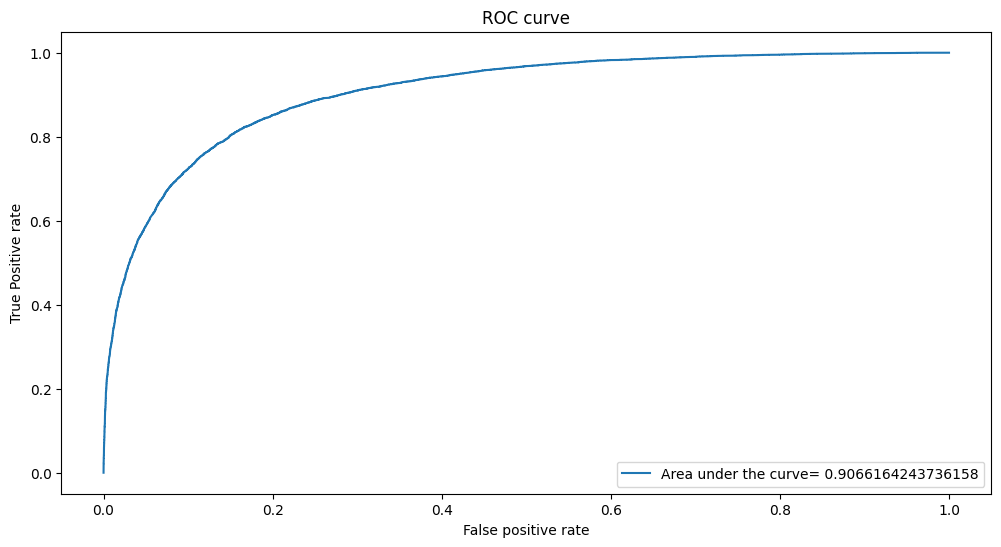

In [39]:
y_pred = svc.predict(test_features)
y_pred_proba = svc.predict_proba(test_features)[::,1]

# evaluate the model
evaluate(test_labels, y_pred, y_pred_proba)

### Quantum ML

#### Angle Encoding

/Users/liamjones/Library/Python/3.9/lib/python/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


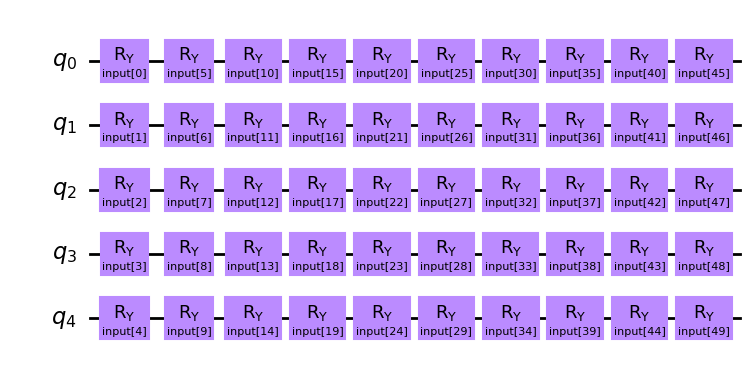

In [10]:
num_features = features.shape[1]

params = ParameterVector("input", num_features)
qc_angle = QuantumCircuit(5)

qc_angle.ry(params[0], [0])
qc_angle.ry(params[1], [1])
qc_angle.ry(params[2], [2])
qc_angle.ry(params[3], [3])
qc_angle.ry(params[4], [4])
qc_angle.ry(params[5], [0])
qc_angle.ry(params[6], [1])
qc_angle.ry(params[7], [2])
qc_angle.ry(params[8], [3])
qc_angle.ry(params[9], [4])
qc_angle.ry(params[10], [0])
qc_angle.ry(params[11], [1])
qc_angle.ry(params[12], [2])
qc_angle.ry(params[13], [3])
qc_angle.ry(params[14], [4])
qc_angle.ry(params[15], [0])
qc_angle.ry(params[16], [1])
qc_angle.ry(params[17], [2])
qc_angle.ry(params[18], [3])
qc_angle.ry(params[19], [4])
qc_angle.ry(params[20], [0])
qc_angle.ry(params[21], [1])
qc_angle.ry(params[22], [2])
qc_angle.ry(params[23], [3])
qc_angle.ry(params[24], [4])
qc_angle.ry(params[25], [0])
qc_angle.ry(params[26], [1])
qc_angle.ry(params[27], [2])
qc_angle.ry(params[28], [3])
qc_angle.ry(params[29], [4])
qc_angle.ry(params[30], [0])
qc_angle.ry(params[31], [1])
qc_angle.ry(params[32], [2])
qc_angle.ry(params[33], [3])
qc_angle.ry(params[34], [4])
qc_angle.ry(params[35], [0])
qc_angle.ry(params[36], [1])
qc_angle.ry(params[37], [2])
qc_angle.ry(params[38], [3])
qc_angle.ry(params[39], [4])
qc_angle.ry(params[40], [0])
qc_angle.ry(params[41], [1])
qc_angle.ry(params[42], [2])
qc_angle.ry(params[43], [3])
qc_angle.ry(params[44], [4])
qc_angle.ry(params[45], [0])
qc_angle.ry(params[46], [1])
qc_angle.ry(params[47], [2])
qc_angle.ry(params[48], [3])
qc_angle.ry(params[49], [4])

qc_angle.draw("mpl")

/Users/liamjones/Library/Python/3.9/lib/python/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


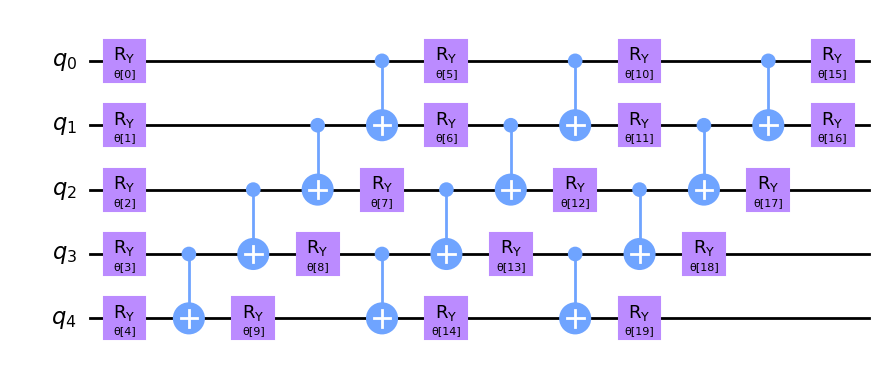

In [11]:
ansatz_angle = RealAmplitudes(num_qubits=5, reps=3, parameter_prefix='θ')
ansatz_angle.decompose().draw(output="mpl", fold=20)

In [12]:
optimizer = COBYLA(maxiter=20)

sampler = Sampler()

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

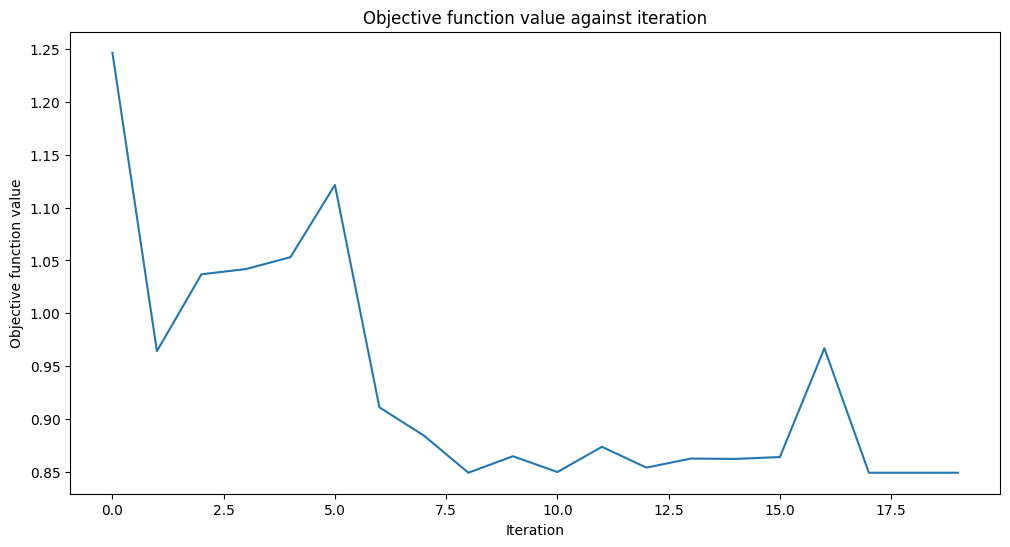

Training time: 5792 seconds


In [13]:
vqc_angle = VQC(
    sampler=sampler,
    feature_map=qc_angle,
    ansatz=ansatz_angle,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc_angle.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [14]:
train_score_q_angle = vqc_angle.score(train_features, train_labels)
test_score_q_angle = vqc_angle.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q_angle:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q_angle:.2f}")

Quantum VQC on the training dataset: 0.72
Quantum VQC on the test dataset:     0.71


#### Amplitude Encoding

/Users/liamjones/Library/Python/3.9/lib/python/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


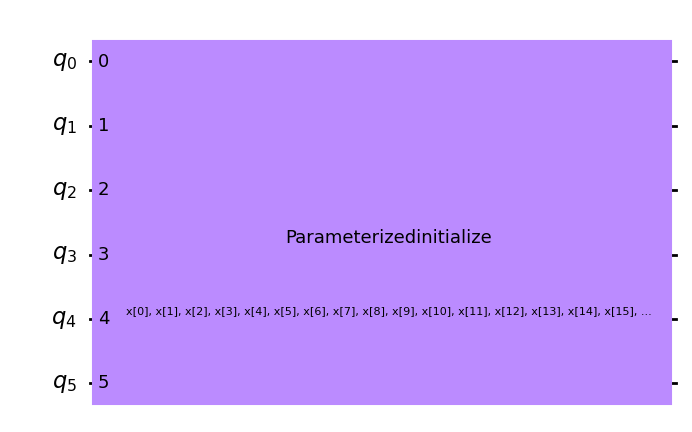

In [15]:
qc_amp = RawFeatureVector(64)
qc_amp.draw("mpl")

In [16]:
features_pad = []

for i in range(len(features)):
    pad = np.append(features[i],[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
    features_pad.append(pad)
    
features_pad = np.array(features_pad)

print(features_pad.shape)
    
train_features_pad, test_features_pad, train_labels_pad, test_labels_pad = train_test_split(
    features_pad, labels_new, train_size=0.7, random_state=algorithm_globals.random_seed)

(130064, 64)


In [17]:
print(train_labels_pad, test_labels_pad)

[1 0 1 ... 1 1 0] [0 0 0 ... 0 1 0]


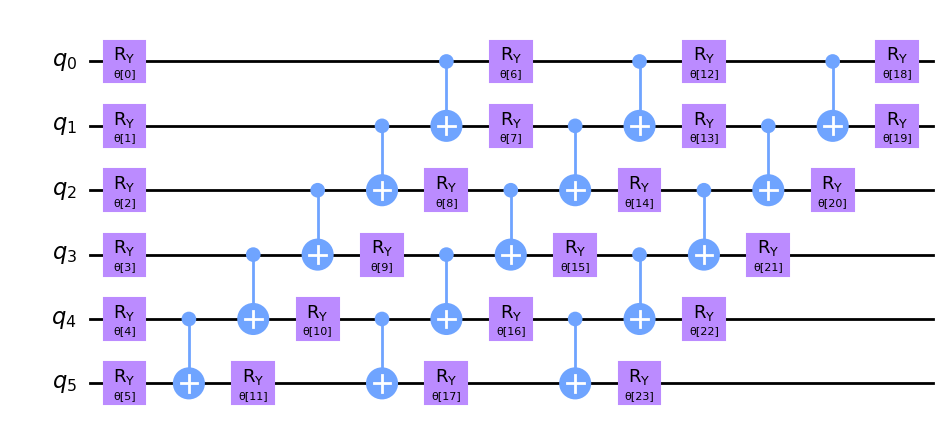

In [18]:
ansatz_amp = RealAmplitudes(num_qubits=6, reps=3, parameter_prefix='θ')
ansatz_amp.decompose().draw(output="mpl", fold=20)

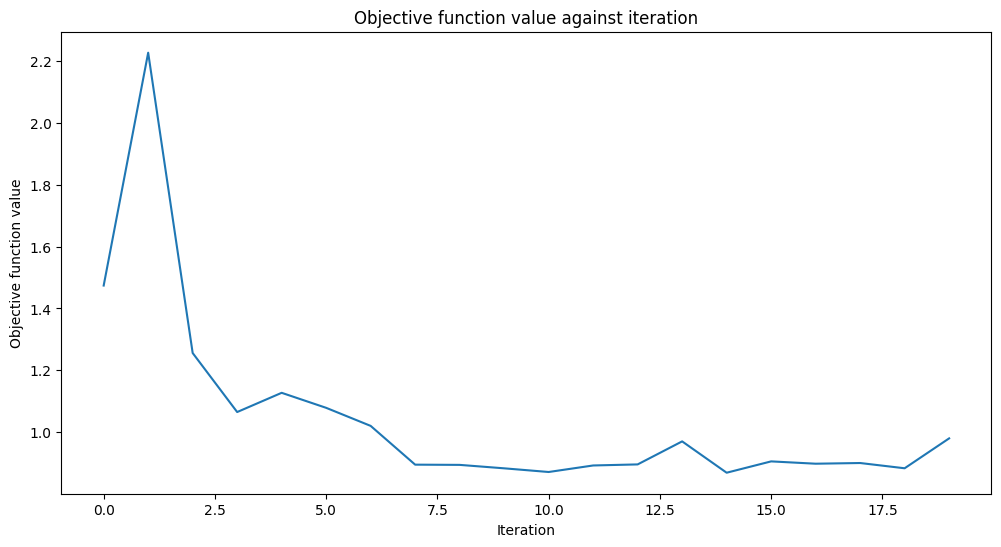

Training time: 8604 seconds


In [19]:
vqc_amp = VQC(
          sampler=sampler,
          feature_map=qc_amp,
          ansatz=ansatz_amp,
          optimizer=optimizer,
          callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc_amp.fit(train_features_pad, train_labels_pad)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [20]:
train_score_q_amp = vqc_amp.score(train_features_pad, train_labels_pad)
test_score_q_amp = vqc_amp.score(test_features_pad, test_labels_pad)

print(f"Quantum VQC on the training dataset: {train_score_q_amp:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q_amp:.2f}")

Quantum VQC on the training dataset: 0.72
Quantum VQC on the test dataset:     0.72


### Evaluation

In [40]:
y_pred_amp = vqc_amp.predict(test_features_pad)
y_pred_proba_amp = vqc_amp.predict_proba(test_features_pad)[::,1]

AttributeError: 'VQC' object has no attribute 'predict_proba'

In [32]:
evaluate(test_labels_pad, y_pred_amp, y_pred_proba_amp)

InvalidParameterError: The 'y_score' parameter of roc_curve must be an array-like. Got 0.7168375192209123 instead.

### QSVC

In [48]:
fidelity = ComputeUncompute(sampler=sampler)

kernel_amp = FidelityQuantumKernel(fidelity=fidelity, feature_map=qc_angle)

In [ ]:
qsvc_amp = QSVC(quantum_kernel=kernel_amp) #angle not amplitude

start = time.time()
qsvc_amp.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")
print()

qsvc_amp_score_train = qsvc_amp.score(train_features, train_labels)
qsvc_amp_score = qsvc_amp.score(test_features, test_labels)

print(f"QSVC classification train score: {qsvc_score_amp_train}")
print(f"QSVC classification test score: {qsvc_amp_score}")

In [ ]:
y_pred = qsvc_amp.predict(test_features)
y_pred_proba = qsvc_amp.predict_proba(test_features)[::,1]

# evaluate the model
evaluate(test_labels, y_pred, y_pred_proba)